In [219]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import linalg
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [220]:
df = pd.read_csv("cs-training.csv", index_col = 0)
print(len(df))
df = df.dropna()
print(len(df))
X_cols = list(df.columns)
X_cols.remove("SeriousDlqin2yrs")
X = df[X_cols].to_numpy()
y = df["SeriousDlqin2yrs"].to_numpy()

150000
120269


In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Premilinaries

<AxesSubplot:>

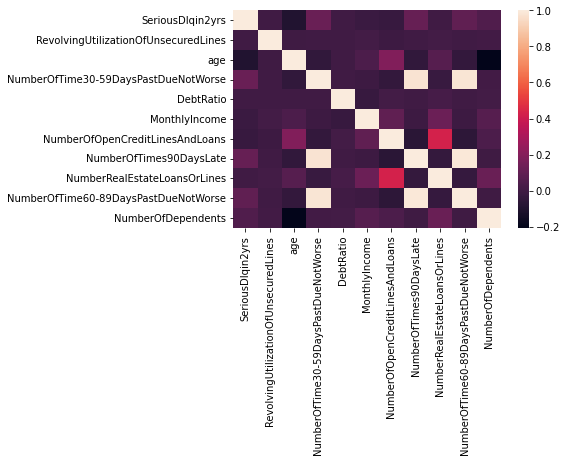

In [222]:
# Correlation Matrix
Corr_Matrix = df.corr()
round(Corr_Matrix, 2)
sns.heatmap(Corr_Matrix)

# Fisher LDA

In [223]:
mu = np.mean(X_train)
X_train_demeaned = (X_train - mu).T
X_test_demeaned = (X_test - mu).T
S_t = np.cov(X_train_demeaned)
S_w = np.zeros(S_t.shape)
for c in np.unique(y_train):
    S_w += np.cov(X_train_demeaned[:, y_train == c])

S_b = S_t - S_w

vals, vecs = linalg.eig(np.linalg.inv(S_w)@S_b)
vecs = vecs[:, np.argsort(vals)]

W_lda = vecs[:, -1:].real

X_train_lda = (W_lda.T@X_train_demeaned).T
X_test_lda = (W_lda.T@X_test_demeaned).T


print(np.mean(X_train_lda[y_train == 0]), np.mean(X_train_lda[y_train == 1]))
print(np.mean(X_test_lda[y_test == 0]), np.mean(X_test_lda[y_test == 1]))

85.44373421739633 83.43138114569865
85.49241455143215 83.98570707600669


In [224]:
y_train

array([0, 0, 0, ..., 0, 1, 0])

# Logistic Regression

In [252]:
from sklearn.linear_model import LogisticRegression
Clf = LogisticRegression(random_state = 0, max_iter = 1000).fit(X_train, y_train)
Probs = Clf.predict_proba(X_train)

Train_Predicted = np.zeros(len(Probs))
for i in range(len(Probs)):
    if (Probs[i, 0] > Probs[i, 1]):  
        Train_Predicted[i] = 0
    else:
        Train_Predicted[i] = 1  
        
print(Probs)
Equal = 0
default = 0
non_default = 0
for i in range(len(y_train)):
    if(y_train[i] == 1):
        if(y_train[i] == Train_Predicted[i]):
            Equal += 1
            default += 1
    else:
        if(y_train[i] == Train_Predicted[i]):
            Equal += 1
            non_default += 1        


Score = Probs[:, 1]/(1 - Probs[:, 1])
print("Scores Are:")
print(np.sum(Score[y_train == 0]))
print(np.mean(Score[y_train == 0]), np.mean(Score[y_train == 1]))

[[0.60631324 0.39368676]
 [0.61522804 0.38477196]
 [0.645425   0.354575  ]
 ...
 [0.12097578 0.87902422]
 [0.43390395 0.56609605]
 [0.37093198 0.62906802]]
Scores Are:
inf
inf inf


/var/folders/9w/fljc9lns4g94k33j57yk2w8r0000gn/T/ipykernel_17308/2197870735.py:27: RuntimeWarning: divide by zero encountered in true_divide
  Score = Probs[:, 1]/(1 - Probs[:, 1])


In [244]:
print("Classification Accuracy on Training Set is:")
print(Equal/len(y_train))
print("Classification Accuracy on Non-Default Training Set is:")
print(non_default/(len(y_train) - np.sum(y_train)))
print("Classification Accuracy on Default Training Set is:")
print(default/np.sum(y_train))

Classification Accuracy on Training Set is:
0.7264549133797267
Classification Accuracy on Non-Default Training Set is:
0.8742750483301113
Classification Accuracy on Default Training Set is:
0.5780888276305048


In [226]:
print("Classification Accuracy on Training Set is:")
print(Equal/len(y_train))

Classification Accuracy on Training Set is:
0.9314594192107223


In [253]:
Probs = Clf.predict_proba(X_test)
Test_Predicted = np.zeros(len(Probs))

for i in range(len(Probs)):
    if (Probs[i, 0] > Probs[i, 1]):  
        Test_Predicted[i] = 0
    else:
        Test_Predicted[i] = 1

        
Equal_test = 0
default_test = 0
non_default_test = 0
for i in range(len(y_test)):
    if(y_test[i] == 1):
        if(y_test[i] == Test_Predicted[i]):
            Equal_test += 1
            default_test += 1
    else:
        if(y_test[i] == Test_Predicted[i]):
            Equal_test += 1
            non_default_test += 1
        
        
        
Score = Probs[:, 1]/(1 - Probs[:, 1])
print("Scores Are:")
print(np.mean(Score[y_test == 0]), np.mean(Score[y_test == 1]))

Scores Are:
inf inf


/var/folders/9w/fljc9lns4g94k33j57yk2w8r0000gn/T/ipykernel_17308/2232123602.py:26: RuntimeWarning: divide by zero encountered in true_divide
  Score = Probs[:, 1]/(1 - Probs[:, 1])


In [254]:
print("Classification Accuracy on Test Set is:")
print(Equal_test/len(y_test))
print("Classification Accuracy on Non-Default Test Set is:")
print(non_default_test/(len(y_test) - np.sum(y_test)))
print("Classification Accuracy on Default Test Set is:")
print(default_test/np.sum(y_test))

Classification Accuracy on Test Set is:
0.853309481216458
Classification Accuracy on Non-Default Test Set is:
0.8743869726610128
Classification Accuracy on Default Test Set is:
0.573687994248742


In [ ]:
print("Classification Accuracy on Test Set is:")
Equal/len(y_test)

# Random Forest

In [255]:
from sklearn.ensemble import RandomForestClassifier
Clf = RandomForestClassifier(max_depth=5, random_state=0)
Clf.fit(X_train, y_train)
Probs = Clf.predict_proba(X_train)

Train_Predicted = np.zeros(len(Probs))
for i in range(len(Probs)):
    if (Probs[i, 0] > Probs[i, 1]):  
        Train_Predicted[i] = 0
    else:
        Train_Predicted[i] = 1
        
Equal = 0
default = 0
non_default = 0
for i in range(len(y_train)):
    if(y_train[i] == 1):
        if(y_train[i] == Train_Predicted[i]):
            Equal += 1
            default += 1
    else:
        if(y_train[i] == Train_Predicted[i]):
            Equal += 1
            non_default += 1          
        
        

Score = Probs[:, 1]/(1 - Probs[:, 1])
print("Scores Are:")
print(np.mean(Score[y_train == 0]), np.mean(Score[y_train == 1]))

Scores Are:
0.8313417522053609 4.447657587995515


In [256]:
print("Classification Accuracy on Training Set is:")
print(Equal/len(y_train))
print("Classification Accuracy on Non-Default Training Set is:")
print(non_default/(len(y_train) - np.sum(y_train)))
print("Classification Accuracy on Default Training Set is:")
print(default/np.sum(y_train))

Classification Accuracy on Training Set is:
0.7735450866202733
Classification Accuracy on Non-Default Training Set is:
0.7703219785347644
Classification Accuracy on Default Training Set is:
0.7767800987568414


In [30]:
print("Classification Accuracy on Training Set is:")
print(Equal/len(y_train))

Classification Accuracy on Training Set is:
0.9345619260362373


In [257]:
Probs = Clf.predict_proba(X_test)

Test_Predicted = np.zeros(len(Probs))

for i in range(len(Probs)):
    if (Probs[i, 0] > Probs[i, 1]):  
        Test_Predicted[i] = 0
    else:
        Test_Predicted[i] = 1

Equal_test = 0
default_test = 0
non_default_test = 0
for i in range(len(y_test)):
    if(y_test[i] == 1):
        if(y_test[i] == Test_Predicted[i]):
            Equal_test += 1
            default_test += 1
    else:
        if(y_test[i] == Test_Predicted[i]):
            Equal_test += 1
            non_default_test += 1

Score = Probs[:, 1]/(1 - Probs[:, 1])
print("Scores Are:")
print(np.mean(Score[y_test == 0]), np.mean(Score[y_test == 1]))

Scores Are:
0.8409225081201817 4.2277328159626775


In [258]:
print("Classification Accuracy on Test Set is:")
print(Equal_test/len(y_test))
print("Classification Accuracy on Non-Default Test Set is:")
print(non_default_test/(len(y_test) - np.sum(y_test)))
print("Classification Accuracy on Default Test Set is:")
print(default_test/np.sum(y_test))

Classification Accuracy on Test Set is:
0.768903222555368
Classification Accuracy on Non-Default Test Set is:
0.7688514373966998
Classification Accuracy on Default Test Set is:
0.7695902228612509


In [32]:
print("Classification Accuracy on Test Set is:")
Equal/len(y_test)

Classification Accuracy on Test Set is:


0.921665952782887

In [29]:
X_train.shape

(115296, 10)

In [78]:
np.sum(y_train)

75006

In [80]:
y_train.shape

(150011,)

In [242]:
default = []
for i in range(len(X_train)):
    if(y_train[i] == 1):
        default.append(X_train[i])
default = np.asarray(default)
        
resampled = []
resampled_y = []
target = X_train.shape[0]/2
current = np.sum(y_train)

while(current <= target):
    index = np.random.choice(default.shape[0], 1)  
    resampled.append(default[index].squeeze())
    resampled_y.append(1)
    current += 1
    target += .498
    
X_train = np.concatenate((X_train, np.asarray(resampled)))
y_train = np.concatenate((y_train, np.asarray(resampled_y)))

# Dense NN

In [207]:
#class_weight = {1: 0.95,0: 0.05}

model_in = keras.Input(shape = (10,))
x = layers.Dense(10, activation= "relu")(model_in)
x2 = layers.Dense(10, activation= "relu")(x)
x3 = layers.Dense(10, activation= "relu")(x2)
x4 = layers.Dense(10, activation= "relu")(x3)

out = layers.Dense(1, activation= "sigmoid")(x4)

model = keras.Model(model_in, out)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X_train, y_train, epochs=100,
                batch_size=128,
                shuffle=True)

Epoch 1/100
1170/1170 [==============================] - 2s 1ms/step - loss: 3.6246
Epoch 2/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.7017
Epoch 3/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.6768
Epoch 4/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.6871
Epoch 5/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.7100
Epoch 6/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.6830
Epoch 7/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.6836
Epoch 8/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.6724
Epoch 9/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.6803
Epoch 10/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.6353
Epoch 11/100
1170/1170 [==============================] - 1s 1ms/step - loss: 0.5888
Epoch 12/100
1170/1170 [==============================] - 1s 1ms/step - lo

In [213]:
Probs = model.predict(X_train)
Probs_test = model.predict(X_test)

Probs

array([[0.2691541 ],
       [0.27822167],
       [0.27822167],
       ...,
       [0.83549863],
       [0.43416348],
       [0.92692226]], dtype=float32)

In [214]:
Probs_test.shape

(39689, 1)

In [215]:
Train_Predicted = np.zeros(len(Probs))
for i in range(len(Probs)):
    if (Probs[i] < .5):  
        Train_Predicted[i] = 0
    else:
        Train_Predicted[i] = 1

Equal = 0
default = 0
non_default = 0
for i in range(len(y_train)):
    if(y_train[i] == 1):
        if(y_train[i] == Train_Predicted[i]):
            Equal += 1
            default += 1
    else:
        if(y_train[i] == Train_Predicted[i]):
            Equal += 1
            non_default += 1
        
Probs

Score = Probs/(1 - Probs)
print(np.mean(Score[y_train == 0]), np.mean(Score[y_train == 1]))


Test_Predicted = np.zeros(len(Probs_test))
for i in range(len(Probs_test)):
    if (Probs_test[i] < .5):  
        Test_Predicted[i] = 0
    else:
        Test_Predicted[i] = 1

Equal_test = 0
default_test = 0
non_default_test = 0
for i in range(len(y_test)):
    if(y_test[i] == 1):
        if(y_test[i] == Test_Predicted[i]):
            Equal_test += 1
            default_test += 1
    else:
        if(y_test[i] == Test_Predicted[i]):
            Equal_test += 1
            non_default_test += 1
        
Probs

Score_test = Probs_test/(1 - Probs_test)
print(np.mean(Score_test[y_test == 0]), np.mean(Score_test[y_test == 1]))

1.0631742 4.871376
1.0617555 4.7097497


In [211]:
np.sum(Train_Predicted)

68350.0

In [212]:
print("Classification Accuracy on Training Set is:")
print(Equal/len(y_train))
print("Classification Accuracy on Non-Default Training Set is:")
print(non_default/(len(y_train) - np.sum(y_train)))
print("Classification Accuracy on Default Training Set is:")
print(default/np.sum(y_train))

Classification Accuracy on Training Set is:
0.7652036277665727
Classification Accuracy on Non-Default Training Set is:
0.8081594560362643
Classification Accuracy on Default Training Set is:
0.7220891487909646


In [217]:
print("Classification Accuracy on Test Set is:")
print(Equal_test/len(y_test))
print("Classification Accuracy on Non-Default Test Set is:")
print(non_default_test/(len(y_test) - np.sum(y_test)))
print("Classification Accuracy on Default Test Set is:")
print(default_test/np.sum(y_test))

Classification Accuracy on Test Set is:
0.8031948398800676
Classification Accuracy on Non-Default Test Set is:
0.8090877069390631
Classification Accuracy on Default Test Set is:
0.7250179726815241
